In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 1024  #'full'
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(umap_prop)
    + "_"
    + str(PROJECTION_DIMS)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_1.0_1024_1024____2020_08_09_12_10_22_485917_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

block_layers_num = 3
weight_decay = 1e-4
name = 'resnet20'
def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer


def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out



input_ = Input(shape=dims)
x =input_
x = conv2d_bn_relu(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

# # conv 2
for i in range(block_layers_num):
    x = ResidualBlock(x, filters=16, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
# # conv 3
x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
for i in range(block_layers_num - 1):
    x = ResidualBlock(x, filters=32, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
# # conv 4
x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
for i in range(block_layers_num - 1):
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
x = AveragePooling2D(pool_size=(8, 8), padding='valid')(x)
x = Flatten()(x)

x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.9)(x)
x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.9)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions")(x)

model = Model(input_, x, name=name)

In [9]:
model.summary()

Model: "resnet20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [19]:
model.compile(tf.keras.optimizers.Adam(1e-4), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [20]:
history = model.fit(
    X_labeled,
    Y_labeled,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_valid, Y_valid),
    callbacks = [early_stopping]
)

Epoch 1/100
80/80 [==============================] - 2s 31ms/step - loss: 1.5507 - accuracy: 0.3873 - val_loss: 1.9142 - val_accuracy: 0.3356
Epoch 2/100
80/80 [==============================] - 2s 25ms/step - loss: 1.5216 - accuracy: 0.3965 - val_loss: 2.1100 - val_accuracy: 0.3232
Epoch 3/100
80/80 [==============================] - 2s 25ms/step - loss: 1.5080 - accuracy: 0.4057 - val_loss: 1.9299 - val_accuracy: 0.3434
Epoch 4/100
80/80 [==============================] - 2s 25ms/step - loss: 1.4845 - accuracy: 0.4150 - val_loss: 2.1053 - val_accuracy: 0.3302
Epoch 5/100
80/80 [==============================] - 2s 25ms/step - loss: 1.4784 - accuracy: 0.4118 - val_loss: 2.0688 - val_accuracy: 0.3454
Epoch 6/100
80/80 [==============================] - 2s 25ms/step - loss: 1.4562 - accuracy: 0.4120 - val_loss: 2.1063 - val_accuracy: 0.3452
Epoch 7/100
80/80 [==============================] - 2s 25ms/step - loss: 1.4573 - accuracy: 0.4182 - val_loss: 2.0436 - val_accuracy: 0.2762
Epoch 

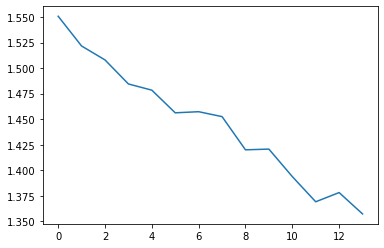

In [21]:
plt.plot(history.history['loss'])

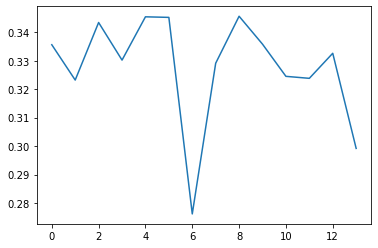

In [22]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])

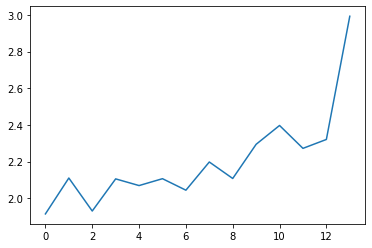